<a href="https://colab.research.google.com/github/Hanna07111/PaperCodeReview/blob/main/LIMP/compute_prob_GPT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### utterance&action likelihood
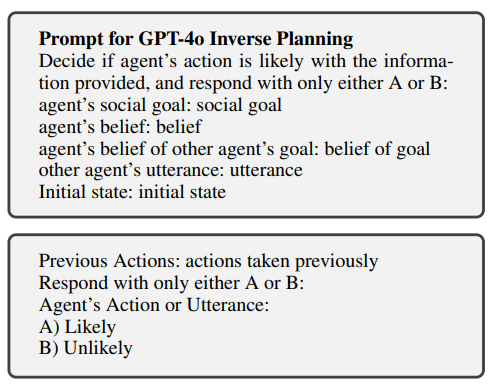

In [ ]:
def compute_prob_utterance(name_agent_0, name_agent_1, utterance_agent_0, utterance_agent_1, a1_social_goal, a1_belief, a1_belief_of_goal, init_state, exclude=[]):
    # agent_1의 사회적, 목표, 믿음 추가
    evaluation_prompt = f"""
    {name_agent_1}'s social goal: {a1_social_goal}
    {name_agent_1}'s belief: {a1_belief}
    """

    # agent_1의 agent_2의 목표에 대한 믿음도 추가
    if "Believed_Goal" not in exclude:
        evaluation_prompt += f"{name_agent_1}'s belief of {name_agent_0}'s goal: {a1_belief_of_goal}\n"

    # agent_0이 직전에 말한 내용
    evaluation_prompt += f"{name_agent_0}'s Utterance': {utterance_agent_0}\n"

    # 초기 상태
    if init_state is not None:
        evaluation_prompt += f"Initial state of environment: {init_state}\n"

    # 주어진 조건에서 해당 발화의 likelihood 계산
    # A 또는 B로 답변
    evaluation_prompt += f"""
    Based on the information, decide if it is likely for {name_agent_1} to say this word given conditions above. Compare the utterance and the belief of {name_agent_1}.
    When trying to hinder, {name_agent_1} is likely to give different information with belief. For example, saying that some object is there when {name_agent_1} believe that there is some other things or nothing there, or the object is at a different place.
    Respond with only either A or B:
    {name_agent_1}'s Utterance: {utterance_agent_1}
    A) Likely
    B) Unlikely
    """
    #print("prompt:", evaluation_prompt)
    response2 = client.chat.completions.create(
        messages=[
            {"role": "system", "content": evaluation_prompt},
        ],
        model="gpt-4o",
        logprobs=True, # A,B의 토큰 log probability로 계산
        top_logprobs=5,
        temperature=0.0
    )

    # json으로 직렬화 (?)
    response_json_str = response2.model_dump_json(indent=2)

    # 딕셔너리로 변환
    response_dict = json.loads(response_json_str)
    logprob_a = None

    # A) Likely 를 선택했을 때의 log probability 획득
    for top_logprob in response_dict['choices'][0]['logprobs']['content'][0]['top_logprobs']:
        if top_logprob['token'] == 'A':
            logprob_a = top_logprob['logprob']
        elif top_logprob['token'] == 'B':
            logprob_b = top_logprob['logprob']

    # 실제 확률로 변환 (이 땐 A의 확률만 사용 => likelihood를 구하고 싶은 거니까)
    prob_a = math.exp(logprob_a) if logprob_a is not None else 0.0
    return prob_a

In [ ]:
def compute_prob_action(name_agent_0, name_agent_1, init_state, previous_actions, a1_action, a1_social_goal, a1_belief, a1_belief_of_goal):
    evaluation_prompt = f"""
    Decide if {name_agent_1}'s action is likely with the information provided, respond with only either A or B:
    {name_agent_0}'s social goal: {a1_social_goal}
    {name_agent_1}'s belief: {a1_belief}
    {name_agent_1}'s belief of {name_agent_0}'s goal: {a1_belief_of_goal}
    Initial state: {init_state}
    Check {name_agent_0}'s action to get the location of object when {name_agent_1} starts to act.
    When {name_agent_1} tries to hinder, it's likely to grab object from its believed goal location for other agent, and unlikely to move objects to the believed goal location
    When {name_agent_1} tries to help, it's likely to grab object from somewhere else and put it to believed goal location, and unlikely to grab object from believed goal location
    Walking towards or grabbing from some unrelated location should be considered likely
    Previous Actions: {previous_actions}
    {name_agent_1}'s Action: {a1_action}
    A) Likely
    B) Unlikely
    """

    response2 = client.chat.completions.create(
        messages=[
            {"role": "system", "content": evaluation_prompt},
        ],
        model="gpt-4o",
        logprobs=True,
        top_logprobs=5,
        temperature=0.0
    )

    response_json_str = response2.model_dump_json(indent=2)
    response_dict = json.loads(response_json_str)
    logprob_a = None


    for top_logprob in response_dict['choices'][0]['logprobs']['content'][0]['top_logprobs']:
        if top_logprob['token'] == 'A':
            logprob_a = top_logprob['logprob']
        elif top_logprob['token'] == 'B':
            logprob_b = top_logprob['logprob']

    prob_a = math.exp(logprob_a) if logprob_a is not None else None
    return prob_a